In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Load Service 1 results
service1_df = pd.read_csv('../../../results/Service1.csv')

In [16]:
# --- Basic Checks ---
print("Null values:\n", service1_df.isnull().sum())
print("\nData types:\n", service1_df.dtypes)

Null values:
 timestamp           0
cpu_allocated       0
memory_allocated    0
cpu_usage_pct       0
memory_usage_pct    0
latency_ms          0
dtype: int64

Data types:
 timestamp            object
cpu_allocated       float64
memory_allocated    float64
cpu_usage_pct       float64
memory_usage_pct    float64
latency_ms          float64
dtype: object


In [18]:
# --- Descriptive Statistics ---
print("\nDescriptive stats:\n", service1_df.describe())


Descriptive stats:
        cpu_allocated  memory_allocated  cpu_usage_pct  memory_usage_pct  \
count   10000.000000      10000.000000   10000.000000      10000.000000   
mean        0.550000       1152.000000      50.000000         10.946165   
std         0.259877        517.383443      40.878341         19.120931   
min         0.100000        256.000000       0.250000          0.000000   
25%         0.327500        703.997500       4.740000          0.030000   
50%         0.550000       1152.000000      50.000000          0.670000   
75%         0.772500       1600.002500      95.260000         11.922500   
max         1.000000       2048.000000      99.750000         73.110000   

         latency_ms  
count  10000.000000  
mean     312.393823  
std      244.759124  
min       41.560000  
25%       90.225000  
50%      143.030000  
75%      561.102500  
max      870.340000  


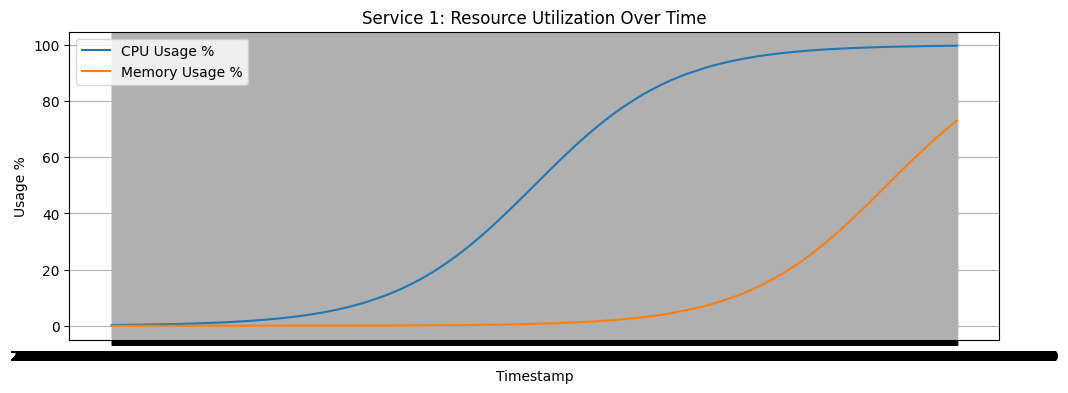

In [21]:
# --- Resource Utilization over Time ---
plt.figure(figsize=(12, 4))
plt.plot(service1_df['timestamp'], service1_df['cpu_usage_pct'], label='CPU Usage %')
plt.plot(service1_df['timestamp'], service1_df['memory_usage_pct'], label='Memory Usage %')
plt.legend()
plt.title("Service 1: Resource Utilization Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Usage %")
plt.grid(True)
plt.show()

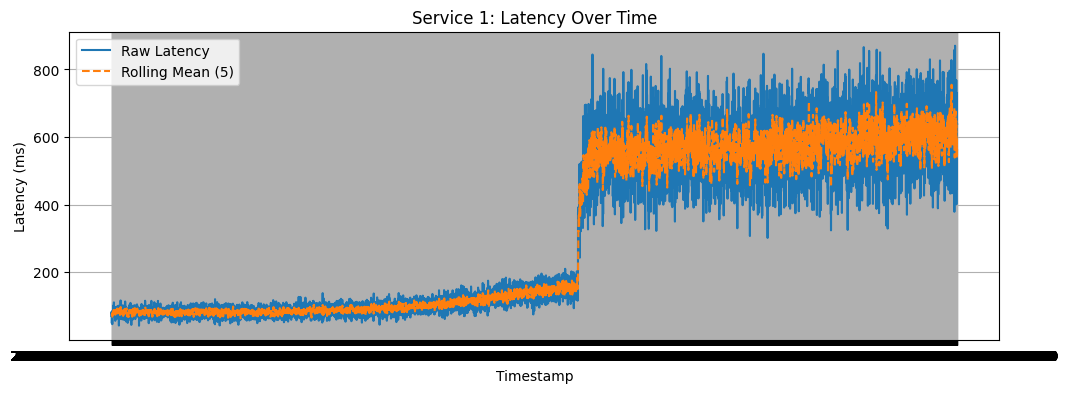

In [20]:
# --- Latency Trend with Rolling Average ---
plt.figure(figsize=(12, 4))
plt.plot(service1_df['timestamp'], service1_df['latency_ms'], label='Raw Latency')
plt.plot(service1_df['timestamp'], service1_df['latency_ms'].rolling(window=5).mean(), label='Rolling Mean (5)', linestyle='--')
plt.legend()
plt.title("Service 1: Latency Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Latency (ms)")
plt.grid(True)
plt.show()

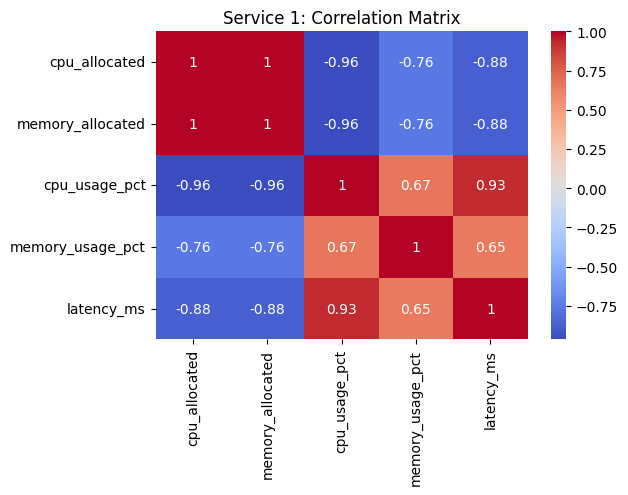

In [38]:
# --- Correlation Analysis ---
plt.figure(figsize=(6, 4))
sns.heatmap(service1_df[['cpu_allocated',  'memory_allocated','cpu_usage_pct', 'memory_usage_pct', 'latency_ms']].corr(), annot=True, cmap='coolwarm')
plt.title("Service 1: Correlation Matrix")
plt.show()

In [43]:
# Print correlation matrix
correlation_matrix = service1_df[['cpu_allocated',  'memory_allocated','cpu_usage_pct', 'memory_usage_pct', 'latency_ms']].corr()
print("Correlation Matrix:\n", correlation_matrix)


Correlation Matrix:
                   cpu_allocated  memory_allocated  cpu_usage_pct  \
cpu_allocated          1.000000          0.999938      -0.964503   
memory_allocated       0.999938          1.000000      -0.964577   
cpu_usage_pct         -0.964503         -0.964577       1.000000   
memory_usage_pct      -0.764306         -0.764334       0.666404   
latency_ms            -0.875616         -0.875742       0.928154   

                  memory_usage_pct  latency_ms  
cpu_allocated            -0.764306   -0.875616  
memory_allocated         -0.764334   -0.875742  
cpu_usage_pct             0.666404    0.928154  
memory_usage_pct          1.000000    0.649113  
latency_ms                0.649113    1.000000  


In [26]:
# --- Outlier Detection for Resource Usage and Latency ---

# Z-score Method for outlier detection
z_scores_cpu = zscore(service1_df['cpu_usage_pct'])
z_scores_memory = zscore(service1_df['memory_usage_pct'])
z_scores_latency = zscore(service1_df['latency_ms'])

# Define a threshold for detecting outliers (e.g., 3 standard deviations)
threshold = 3
outliers_cpu = service1_df[abs(z_scores_cpu) > threshold]
outliers_memory = service1_df[abs(z_scores_memory) > threshold]
outliers_latency = service1_df[abs(z_scores_latency) > threshold]

In [27]:
# Print outliers
print("\nOutliers based on Z-score:")
print(f"CPU Usage Outliers: {outliers_cpu.shape[0]}")
print(f"Memory Usage Outliers: {outliers_memory.shape[0]}")
print(f"Latency Outliers: {outliers_latency.shape[0]}")


Outliers based on Z-score:
CPU Usage Outliers: 0
Memory Usage Outliers: 194
Latency Outliers: 0


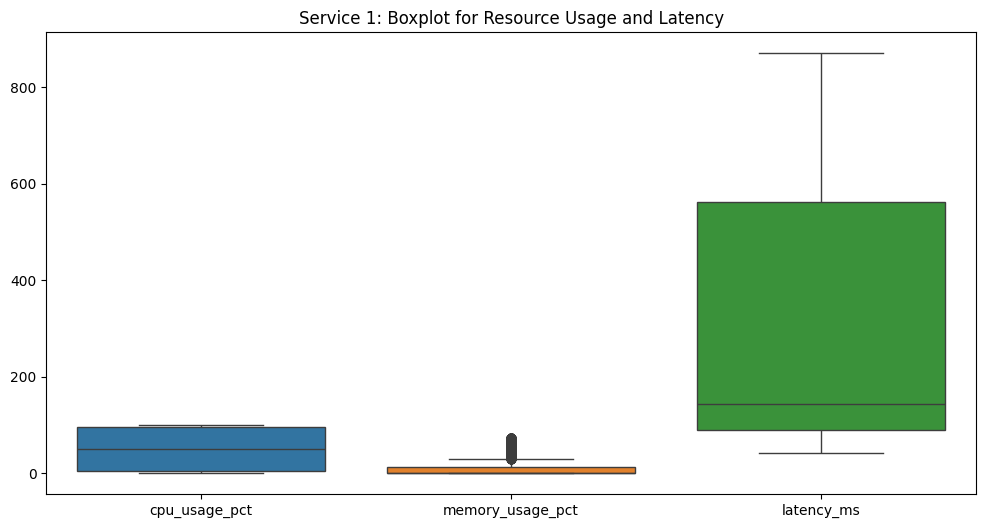

In [29]:
# Boxplot for visual outlier detection
plt.figure(figsize=(12, 6))
sns.boxplot(data=service1_df[['cpu_usage_pct', 'memory_usage_pct', 'latency_ms']])
plt.title("Service 1: Boxplot for Resource Usage and Latency")
plt.show()

In [34]:
# Function to detect spikes using rolling mean and rolling std
def detect_spikes(df, window_size, threshold=3):
    df['rolling_mean'] = df['latency_ms'].rolling(window=window_size).mean()
    df['rolling_std'] = df['latency_ms'].rolling(window=window_size).std()
    
    outliers_spikes = df[abs(df['latency_ms'] - df['rolling_mean']) > threshold * df['rolling_std']]
    return len(outliers_spikes)

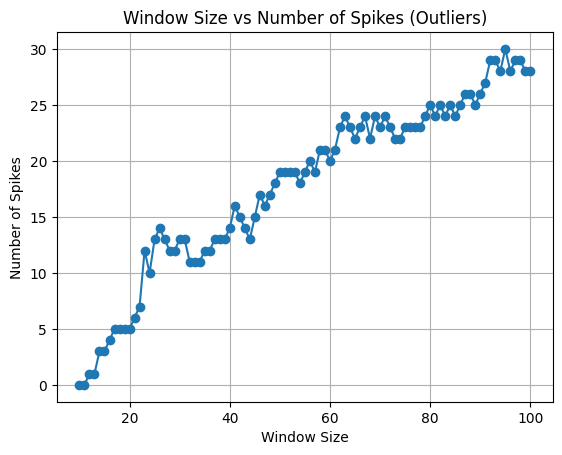

In [35]:
# List to store window sizes and number of spikes detected
window_sizes = list(range(10, 101))
spikes_count = []

# Loop over window sizes and detect spikes
for window_size in window_sizes:
    num_spikes = detect_spikes(service1_df, window_size)
    spikes_count.append(num_spikes)

# Plot the relationship between window size and number of spikes
plt.plot(window_sizes, spikes_count, marker='o')
plt.title('Window Size vs Number of Spikes (Outliers)')
plt.xlabel('Window Size')
plt.ylabel('Number of Spikes')
plt.grid(True)
plt.show()

In [36]:
# Step 1: Calculate latency difference between consecutive timestamps
service1_df['latency_diff'] = service1_df['latency_ms'].diff()

# Step 2: Define a spike (latency difference greater than the mean latency)
threshold = service1_df['latency_ms'].mean()  # Define threshold as mean latency
service1_df['is_spike'] = service1_df['latency_diff'] > threshold

# Step 3: Select spike windows (rows where spikes occurred)
spike_windows = service1_df[service1_df['is_spike']]

# Step 4: Analyze CPU and memory usage around the spike times
for i, row in spike_windows.iterrows():
    print(f"Spike at {row['timestamp']} | CPU: {row['cpu_usage_pct']}% | Mem: {row['memory_usage_pct']}%")

Spike at 2025-05-07 14:36:34.233160 | CPU: 69.53% | Mem: 1.51%
Spike at 2025-05-07 16:43:34.233160 | CPU: 72.66% | Mem: 1.76%
Spike at 2025-05-07 21:24:34.233160 | CPU: 78.83% | Mem: 2.45%
Spike at 2025-05-08 01:00:34.233160 | CPU: 82.83% | Mem: 3.15%
Spike at 2025-05-08 02:06:34.233160 | CPU: 83.93% | Mem: 3.4%
Spike at 2025-05-08 05:37:34.233160 | CPU: 87.06% | Mem: 4.34%
Spike at 2025-05-08 05:52:34.233160 | CPU: 87.26% | Mem: 4.41%
Spike at 2025-05-08 06:52:34.233160 | CPU: 88.04% | Mem: 4.73%
Spike at 2025-05-08 10:33:34.233160 | CPU: 90.56% | Mem: 6.07%
Spike at 2025-05-08 11:30:34.233160 | CPU: 91.13% | Mem: 6.48%
Spike at 2025-05-08 21:39:34.233160 | CPU: 95.53% | Mem: 12.57%
Spike at 2025-05-09 00:02:34.233160 | CPU: 96.2% | Mem: 14.59%
Spike at 2025-05-09 01:08:34.233160 | CPU: 96.48% | Mem: 15.6%
Spike at 2025-05-09 11:25:34.233160 | CPU: 98.29% | Mem: 27.93%
Spike at 2025-05-09 12:11:34.233160 | CPU: 98.38% | Mem: 29.06%
Spike at 2025-05-09 14:57:34.233160 | CPU: 98.67% | M